# ORF recognition by Convolutional/Recurrent

So far CNN+LSTM 64 overfits the 128 base RNA problem.
That was using 32K samples/class. Here, try more samples. 

Also, build the model without specifying INPUT_SIZE.



In [1]:
import time 
t = time.time()
time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t))

'2021-06-22 17:31:18 UTC'

In [2]:
PC_SEQUENCES=64000   # how many protein-coding sequences
NC_SEQUENCES=64000   # how many non-coding sequences
PC_TESTS=1000
NC_TESTS=1000
RNA_LEN=128            # how long is each sequence
CDS_LEN=64            # min CDS len to be coding
ALPHABET=4          # how many different letters are possible
INPUT_SHAPE_2D = (RNA_LEN,ALPHABET,1) # Conv2D needs 3D inputs
INPUT_SHAPE = (RNA_LEN,ALPHABET) # Conv1D needs 2D inputs
FILTERS = 64   # how many different patterns the model looks for
CELLS = 64
NEURONS = 64
DROP_RATE = 0.4
WIDTH = 3   # how wide each pattern is, in bases
STRIDE_2D = (1,1)  # For Conv2D how far in each direction
STRIDE = 1 # For Conv1D, how far between pattern matches, in bases
EPOCHS=100  # how many times to train on all the data
SPLITS=3  # SPLITS=3 means train on 2/3 and validate on 1/3 
FOLDS=3  # train the model this many times (range 1 to SPLITS)

In [3]:
import sys
IN_COLAB = False
try:
    from google.colab import drive
    IN_COLAB = True
except:
    pass
if IN_COLAB:
    print("On Google CoLab, mount cloud-local file, get our code from GitHub.")
    PATH='/content/drive/'
    #drive.mount(PATH,force_remount=True)  # hardly ever need this
    #drive.mount(PATH)    # Google will require login credentials
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
    import requests
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_describe.py')
    with open('RNA_describe.py', 'w') as f:
        f.write(r.text)  
    from RNA_describe import ORF_counter
    from RNA_describe import Random_Base_Oracle
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_prep.py')
    with open('RNA_prep.py', 'w') as f:
        f.write(r.text)  
    from RNA_prep import prepare_inputs_len_x_alphabet
else:
        print("CoLab not working. On my PC, use relative paths.")
        DATAPATH='data/'  # must end in "/"
        sys.path.append("..") # append parent dir in order to use sibling dirs
        from SimTools.RNA_describe import ORF_counter,Random_Base_Oracle
        from SimTools.RNA_prep import prepare_inputs_len_x_alphabet

MODELPATH="BestModel"  # saved on cloud instance and lost after logout
#MODELPATH=DATAPATH+MODELPATH  # saved on Google Drive but requires login


On Google CoLab, mount cloud-local file, get our code from GitHub.


In [4]:
from os import listdir
import csv
from zipfile import ZipFile

import numpy as np
import pandas as pd
from scipy import stats  # mode

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from keras.models import Sequential
from keras.layers import Dense,Embedding,Dropout
from keras.layers import Conv1D,Conv2D
from keras.layers import GRU,LSTM
from keras.layers import Flatten,TimeDistributed
from keras.layers import MaxPooling1D,MaxPooling2D
from keras.losses import BinaryCrossentropy
# tf.keras.losses.BinaryCrossentropy

import matplotlib.pyplot as plt
from matplotlib import colors
mycmap = colors.ListedColormap(['red','blue'])  # list color for label 0 then 1
np.set_printoptions(precision=2)


In [5]:
rbo=Random_Base_Oracle(RNA_LEN,True)
pc_all,nc_all = rbo.get_partitioned_sequences(CDS_LEN,10) # just testing
pc_all,nc_all = rbo.get_partitioned_sequences(CDS_LEN,PC_SEQUENCES+PC_TESTS)
print("Use",len(pc_all),"PC seqs")
print("Use",len(nc_all),"NC seqs")

It took 53 trials to reach 10 per class.
It took 256597 trials to reach 65000 per class.
Use 65000 PC seqs
Use 65000 NC seqs


In [6]:
# Describe the sequences
def describe_sequences(list_of_seq):
    oc = ORF_counter()
    num_seq = len(list_of_seq)
    rna_lens = np.zeros(num_seq)
    orf_lens = np.zeros(num_seq)
    for i in range(0,num_seq):
        rna_len = len(list_of_seq[i])
        rna_lens[i] = rna_len
        oc.set_sequence(list_of_seq[i])
        orf_len = oc.get_max_orf_len()
        orf_lens[i] = orf_len
    print ("Average RNA length:",rna_lens.mean())
    print ("Average ORF length:",orf_lens.mean())
    
print("Simulated sequences prior to adjustment:")
print("PC seqs")
describe_sequences(pc_all)
print("NC seqs")
describe_sequences(nc_all)

Simulated sequences prior to adjustment:
PC seqs
Average RNA length: 128.0
Average ORF length: 81.204
NC seqs
Average RNA length: 128.0
Average ORF length: 28.948384615384615


In [7]:
pc_train=pc_all[:PC_SEQUENCES]
nc_train=nc_all[:NC_SEQUENCES]
pc_test=pc_all[PC_SEQUENCES:]
nc_test=nc_all[NC_SEQUENCES:]

In [8]:
# Use code from our SimTools library.
X,y = prepare_inputs_len_x_alphabet(pc_train,nc_train,ALPHABET) # shuffles
print("Data ready.")

Data ready.


In [9]:
def make_DNN():
    print("make_DNN")
    print("input shape:",INPUT_SHAPE)
    dnn = Sequential()
    #dnn.add(Embedding(input_dim=INPUT_SHAPE,output_dim=INPUT_SHAPE)) 
    dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same",
            input_shape=INPUT_SHAPE))
    dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same"))
    dnn.add(MaxPooling1D())
    #dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same"))
    #dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same"))
    #dnn.add(MaxPooling1D())
    #dnn.add(TimeDistributed(Flatten()))
    dnn.add(LSTM(CELLS,return_sequences=True))
    dnn.add(LSTM(CELLS,return_sequences=False))
    dnn.add(Dense(NEURONS,activation="sigmoid",dtype=np.float32))   
    dnn.add(Dropout(DROP_RATE))
    dnn.add(Dense(1,activation="sigmoid",dtype=np.float32))   
    dnn.compile(optimizer='adam',
                loss=BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])   # add to default metrics=loss
    #dnn.build(input_shape=INPUT_SHAPE)   
    dnn.build()   
    #ln_rate = tf.keras.optimizers.Adam(learning_rate = LN_RATE)
    #bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    #model.compile(loss=bc, optimizer=ln_rate, metrics=["accuracy"])
    return dnn
model = make_DNN()
print(model.summary())

make_DNN
input shape: (128, 4)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 128, 64)           832       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 128, 64)           12352     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 64, 64)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 64, 64)            33024     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)        

In [10]:
from keras.callbacks import ModelCheckpoint
def do_cross_validation(X,y):
    cv_scores = []
    fold=0
    mycallbacks = [ModelCheckpoint(
        filepath=MODELPATH, save_best_only=True, 
        monitor='val_accuracy', mode='max')]   
    splitter = KFold(n_splits=SPLITS)  # this does not shuffle
    for train_index,valid_index in splitter.split(X):
        if fold < FOLDS:
            fold += 1
            X_train=X[train_index] # inputs for training
            y_train=y[train_index] # labels for training
            X_valid=X[valid_index] # inputs for validation
            y_valid=y[valid_index] # labels for validation
            print("MODEL")
            # Call constructor on each CV. Else, continually improves the same model.
            model = model = make_DNN()
            print("FIT")  # model.fit() implements learning
            start_time=time.time()
            history=model.fit(X_train, y_train, 
                    epochs=EPOCHS, 
                    verbose=1,  # ascii art while learning
                    callbacks=mycallbacks,   # called at end of each epoch
                    validation_data=(X_valid,y_valid))
            end_time=time.time()
            elapsed_time=(end_time-start_time)                        
            print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
            # print(history.history.keys())  # all these keys will be shown in figure
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1) # any losses > 1 will be off the scale
            plt.show()


MODEL
make_DNN
input shape: (128, 4)
FIT
Epoch 1/100
2667/2667 [==============================] - 72s 13ms/step - loss: 0.7048 - accuracy: 0.5071 - val_loss: 0.6700 - val_accuracy: 0.5867


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 2/100
2667/2667 [==============================] - 34s 13ms/step - loss: 0.6542 - accuracy: 0.6142 - val_loss: 0.6298 - val_accuracy: 0.6387


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 3/100
2667/2667 [==============================] - 34s 13ms/step - loss: 0.6236 - accuracy: 0.6470 - val_loss: 0.5873 - val_accuracy: 0.6824


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 4/100
2667/2667 [==============================] - 34s 13ms/step - loss: 0.5869 - accuracy: 0.6835 - val_loss: 0.5659 - val_accuracy: 0.6948


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 5/100
2667/2667 [==============================] - 34s 13ms/step - loss: 0.5705 - accuracy: 0.6948 - val_loss: 0.5593 - val_accuracy: 0.6996


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 6/100
2667/2667 [==============================] - 34s 13ms/step - loss: 0.5595 - accuracy: 0.6997 - val_loss: 0.5633 - val_accuracy: 0.6901
Epoch 7/100
2667/2667 [==============================] - 34s 13ms/step - loss: 0.5552 - accuracy: 0.7005 - val_loss: 0.5488 - val_accuracy: 0.7030


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 8/100
2667/2667 [==============================] - 34s 13ms/step - loss: 0.5532 - accuracy: 0.7023 - val_loss: 0.5549 - val_accuracy: 0.7011
Epoch 9/100
2667/2667 [==============================] - 34s 13ms/step - loss: 0.5495 - accuracy: 0.7070 - val_loss: 0.5465 - val_accuracy: 0.7035


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 10/100
2667/2667 [==============================] - 34s 13ms/step - loss: 0.5478 - accuracy: 0.7061 - val_loss: 0.5520 - val_accuracy: 0.7011
Epoch 11/100
2667/2667 [==============================] - 34s 13ms/step - loss: 0.5428 - accuracy: 0.7120 - val_loss: 0.5657 - val_accuracy: 0.6945
Epoch 12/100
2667/2667 [==============================] - 34s 13ms/step - loss: 0.5484 - accuracy: 0.7052 - val_loss: 0.5488 - val_accuracy: 0.7056


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 13/100
2667/2667 [==============================] - 34s 13ms/step - loss: 0.5356 - accuracy: 0.7161 - val_loss: 0.5417 - val_accuracy: 0.7087


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 14/100
2667/2667 [==============================] - 34s 13ms/step - loss: 0.5333 - accuracy: 0.7169 - val_loss: 0.5472 - val_accuracy: 0.7075
Epoch 15/100
2667/2667 [==============================] - 34s 13ms/step - loss: 0.5309 - accuracy: 0.7188 - val_loss: 0.5457 - val_accuracy: 0.7043
Epoch 16/100
2667/2667 [==============================] - 34s 13ms/step - loss: 0.5293 - accuracy: 0.7174 - val_loss: 0.5468 - val_accuracy: 0.7042
Epoch 17/100
2667/2667 [==============================] - 38s 14ms/step - loss: 0.5275 - accuracy: 0.7196 - val_loss: 0.5436 - val_accuracy: 0.7067
Epoch 18/100
2667/2667 [==============================] - 34s 13ms/step - loss: 0.5239 - accuracy: 0.7249 - val_loss: 0.5460 - val_accuracy: 0.7081
Epoch 19/100
2667/2667 [==============================] - 34s 13ms/step - loss: 0.5198 - accuracy: 0.7259 - val_loss: 0.5402 - val_accuracy: 0.7113


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 20/100
2667/2667 [==============================] - 34s 13ms/step - loss: 0.5144 - accuracy: 0.7279 - val_loss: 0.5452 - val_accuracy: 0.7076
Epoch 21/100
2667/2667 [==============================] - 34s 13ms/step - loss: 0.5115 - accuracy: 0.7308 - val_loss: 0.5360 - val_accuracy: 0.7128


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 22/100
2667/2667 [==============================] - 34s 13ms/step - loss: 0.5075 - accuracy: 0.7360 - val_loss: 0.5321 - val_accuracy: 0.7187


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 23/100
2667/2667 [==============================] - 34s 13ms/step - loss: 0.4959 - accuracy: 0.7449 - val_loss: 0.5056 - val_accuracy: 0.7487


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 24/100
2667/2667 [==============================] - 34s 13ms/step - loss: 0.5087 - accuracy: 0.7464 - val_loss: 0.5600 - val_accuracy: 0.7030
Epoch 25/100
2667/2667 [==============================] - 34s 13ms/step - loss: 0.5004 - accuracy: 0.7472 - val_loss: 0.4583 - val_accuracy: 0.7747


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 26/100
2667/2667 [==============================] - 34s 13ms/step - loss: 0.5878 - accuracy: 0.6844 - val_loss: 0.5869 - val_accuracy: 0.6794
Epoch 27/100
2667/2667 [==============================] - 34s 13ms/step - loss: 0.5546 - accuracy: 0.7084 - val_loss: 0.4068 - val_accuracy: 0.8216


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 28/100
2667/2667 [==============================] - 33s 13ms/step - loss: 0.3411 - accuracy: 0.8504 - val_loss: 0.2183 - val_accuracy: 0.9032


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 29/100
2667/2667 [==============================] - 34s 13ms/step - loss: 0.2223 - accuracy: 0.9015 - val_loss: 0.3038 - val_accuracy: 0.8743
Epoch 30/100
2667/2667 [==============================] - 34s 13ms/step - loss: 0.2343 - accuracy: 0.8934 - val_loss: 0.1725 - val_accuracy: 0.9172


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 31/100
2667/2667 [==============================] - 34s 13ms/step - loss: 0.1909 - accuracy: 0.9122 - val_loss: 0.5577 - val_accuracy: 0.7135
Epoch 32/100
2667/2667 [==============================] - 34s 13ms/step - loss: 0.4477 - accuracy: 0.7768 - val_loss: 0.1875 - val_accuracy: 0.9131
Epoch 33/100
2667/2667 [==============================] - 33s 12ms/step - loss: 0.1797 - accuracy: 0.9164 - val_loss: 0.1672 - val_accuracy: 0.9201


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 34/100
2667/2667 [==============================] - 33s 13ms/step - loss: 0.1614 - accuracy: 0.9249 - val_loss: 0.1599 - val_accuracy: 0.9238


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 35/100
2667/2667 [==============================] - 33s 13ms/step - loss: 0.1889 - accuracy: 0.9117 - val_loss: 0.4263 - val_accuracy: 0.7886
Epoch 36/100
2667/2667 [==============================] - 34s 13ms/step - loss: 0.2738 - accuracy: 0.8704 - val_loss: 0.1636 - val_accuracy: 0.9215
Epoch 37/100
2667/2667 [==============================] - 34s 13ms/step - loss: 0.1658 - accuracy: 0.9226 - val_loss: 0.1526 - val_accuracy: 0.9248


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 38/100
2667/2667 [==============================] - 34s 13ms/step - loss: 0.1598 - accuracy: 0.9207 - val_loss: 0.6170 - val_accuracy: 0.6560
Epoch 39/100
2667/2667 [==============================] - 34s 13ms/step - loss: 0.5689 - accuracy: 0.6921 - val_loss: 0.2248 - val_accuracy: 0.9003
Epoch 40/100
2667/2667 [==============================] - 34s 13ms/step - loss: 0.1654 - accuracy: 0.9197 - val_loss: 0.1655 - val_accuracy: 0.9222
Epoch 41/100
2667/2667 [==============================] - 34s 13ms/step - loss: 0.4587 - accuracy: 0.7025 - val_loss: 0.6291 - val_accuracy: 0.6453
Epoch 42/100
2667/2667 [==============================] - 34s 13ms/step - loss: 0.6035 - accuracy: 0.6678 - val_loss: 0.5695 - val_accuracy: 0.6903
Epoch 43/100
2667/2667 [==============================] - 33s 13ms/step - loss: 0.5691 - accuracy: 0.6949 - val_loss: 0.5548 - val_accuracy: 0.7033
Epoch 44/100
2667/2667 [==============================] - 34s 13ms/step - loss: 0.5511 - accuracy: 0.7104 - val_

INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 49/100
2667/2667 [==============================] - 34s 13ms/step - loss: 0.1553 - accuracy: 0.9251 - val_loss: 0.1514 - val_accuracy: 0.9301


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 50/100
2667/2667 [==============================] - 38s 14ms/step - loss: 0.1502 - accuracy: 0.9301 - val_loss: 0.1455 - val_accuracy: 0.9311


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 51/100
2667/2667 [==============================] - 34s 13ms/step - loss: 0.1349 - accuracy: 0.9379 - val_loss: 0.1188 - val_accuracy: 0.9450


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 52/100
2667/2667 [==============================] - 34s 13ms/step - loss: 0.1393 - accuracy: 0.9380 - val_loss: 0.1173 - val_accuracy: 0.9434
Epoch 53/100
2667/2667 [==============================] - 34s 13ms/step - loss: 0.1504 - accuracy: 0.9321 - val_loss: 0.1201 - val_accuracy: 0.9423
Epoch 54/100
2667/2667 [==============================] - 34s 13ms/step - loss: 0.1300 - accuracy: 0.9389 - val_loss: 0.1217 - val_accuracy: 0.9426
Epoch 55/100
2667/2667 [==============================] - 34s 13ms/step - loss: 0.1138 - accuracy: 0.9469 - val_loss: 0.1143 - val_accuracy: 0.9477


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 56/100
2667/2667 [==============================] - 34s 13ms/step - loss: 0.1202 - accuracy: 0.9466 - val_loss: 0.1226 - val_accuracy: 0.9452
Epoch 57/100
2667/2667 [==============================] - 34s 13ms/step - loss: 0.1264 - accuracy: 0.9430 - val_loss: 0.1994 - val_accuracy: 0.9170
Epoch 58/100
2667/2667 [==============================] - 34s 13ms/step - loss: 0.1274 - accuracy: 0.9462 - val_loss: 0.0934 - val_accuracy: 0.9600


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 59/100
2667/2667 [==============================] - 34s 13ms/step - loss: 0.1055 - accuracy: 0.9579 - val_loss: 0.0969 - val_accuracy: 0.9634


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 60/100
2667/2667 [==============================] - 34s 13ms/step - loss: 0.0982 - accuracy: 0.9636 - val_loss: 0.0577 - val_accuracy: 0.9779


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 61/100
2667/2667 [==============================] - 38s 14ms/step - loss: 0.0598 - accuracy: 0.9789 - val_loss: 0.0440 - val_accuracy: 0.9831


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 62/100
2667/2667 [==============================] - 34s 13ms/step - loss: 0.0520 - accuracy: 0.9818 - val_loss: 0.4754 - val_accuracy: 0.7748
Epoch 63/100
2667/2667 [==============================] - 34s 13ms/step - loss: 0.2993 - accuracy: 0.8725 - val_loss: 0.1532 - val_accuracy: 0.9334
Epoch 64/100
2667/2667 [==============================] - 34s 13ms/step - loss: 0.1441 - accuracy: 0.9359 - val_loss: 0.1229 - val_accuracy: 0.9454
Epoch 65/100
2667/2667 [==============================] - 34s 13ms/step - loss: 0.4610 - accuracy: 0.7575 - val_loss: 0.5354 - val_accuracy: 0.7219
Epoch 66/100
2667/2667 [==============================] - 34s 13ms/step - loss: 0.4294 - accuracy: 0.7927 - val_loss: 0.1968 - val_accuracy: 0.9178
Epoch 67/100
2667/2667 [==============================] - 34s 13ms/step - loss: 0.1581 - accuracy: 0.9293 - val_loss: 0.6173 - val_accuracy: 0.6651
Epoch 68/100
2667/2667 [==============================] - 34s 13ms/step - loss: 0.6068 - accuracy: 0.6531 - val_

INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 86/100
2667/2667 [==============================] - 33s 13ms/step - loss: 0.0615 - accuracy: 0.9800 - val_loss: 0.0440 - val_accuracy: 0.9843
Epoch 87/100
2667/2667 [==============================] - 33s 13ms/step - loss: 0.0393 - accuracy: 0.9867 - val_loss: 0.0356 - val_accuracy: 0.9878


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 88/100
2667/2667 [==============================] - 34s 13ms/step - loss: 0.0431 - accuracy: 0.9860 - val_loss: 0.0323 - val_accuracy: 0.9889


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 89/100
2667/2667 [==============================] - 34s 13ms/step - loss: 0.0311 - accuracy: 0.9894 - val_loss: 0.0309 - val_accuracy: 0.9884
Epoch 90/100
2667/2667 [==============================] - 34s 13ms/step - loss: 0.0447 - accuracy: 0.9859 - val_loss: 0.0547 - val_accuracy: 0.9817
Epoch 91/100
2667/2667 [==============================] - 34s 13ms/step - loss: 0.0426 - accuracy: 0.9857 - val_loss: 0.0337 - val_accuracy: 0.9875
Epoch 92/100
2667/2667 [==============================] - 34s 13ms/step - loss: 0.0249 - accuracy: 0.9914 - val_loss: 0.0256 - val_accuracy: 0.9909


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 93/100
2667/2667 [==============================] - 34s 13ms/step - loss: 0.0237 - accuracy: 0.9915 - val_loss: 0.0257 - val_accuracy: 0.9903
Epoch 94/100
2667/2667 [==============================] - 34s 13ms/step - loss: 0.0223 - accuracy: 0.9927 - val_loss: 0.0271 - val_accuracy: 0.9897
Epoch 95/100
2667/2667 [==============================] - 34s 13ms/step - loss: 0.0260 - accuracy: 0.9915 - val_loss: 0.0227 - val_accuracy: 0.9909
Epoch 96/100
2667/2667 [==============================] - 34s 13ms/step - loss: 0.0284 - accuracy: 0.9919 - val_loss: 0.0220 - val_accuracy: 0.9921


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 97/100
2667/2667 [==============================] - 34s 13ms/step - loss: 0.0217 - accuracy: 0.9933 - val_loss: 0.0336 - val_accuracy: 0.9879
Epoch 98/100
2667/2667 [==============================] - 34s 13ms/step - loss: 0.0254 - accuracy: 0.9917 - val_loss: 0.0397 - val_accuracy: 0.9873
Epoch 99/100
2667/2667 [==============================] - 34s 13ms/step - loss: 0.0390 - accuracy: 0.9896 - val_loss: 0.0258 - val_accuracy: 0.9906
Epoch 100/100
2667/2667 [==============================] - 34s 13ms/step - loss: 0.0211 - accuracy: 0.9933 - val_loss: 0.0476 - val_accuracy: 0.9840
Fold 1, 100 epochs, 3822 sec


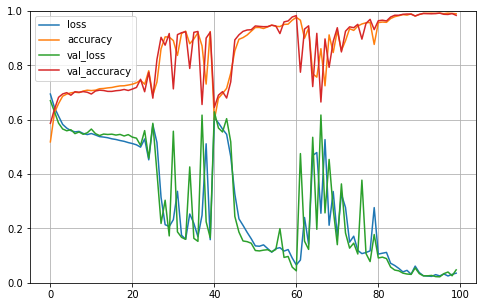

MODEL
make_DNN
input shape: (128, 4)
FIT
Epoch 1/100
2667/2667 [==============================] - 40s 13ms/step - loss: 0.6996 - accuracy: 0.5193 - val_loss: 0.6471 - val_accuracy: 0.6182
Epoch 2/100
2667/2667 [==============================] - 35s 13ms/step - loss: 0.6371 - accuracy: 0.6370 - val_loss: 0.5934 - val_accuracy: 0.6800
Epoch 3/100
2667/2667 [==============================] - 35s 13ms/step - loss: 0.5842 - accuracy: 0.6891 - val_loss: 0.5694 - val_accuracy: 0.6936
Epoch 4/100
2667/2667 [==============================] - 35s 13ms/step - loss: 0.5651 - accuracy: 0.6989 - val_loss: 0.5685 - val_accuracy: 0.6917
Epoch 5/100
2667/2667 [==============================] - 35s 13ms/step - loss: 0.5560 - accuracy: 0.7016 - val_loss: 0.5515 - val_accuracy: 0.7013
Epoch 6/100
2667/2667 [==============================] - 34s 13ms/step - loss: 0.5529 - accuracy: 0.7061 - val_loss: 0.5715 - val_accuracy: 0.6897
Epoch 7/100
2667/2667 [==============================] - 34s 13ms/step - loss

INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 72/100
2667/2667 [==============================] - 34s 13ms/step - loss: 0.0155 - accuracy: 0.9942 - val_loss: 0.0196 - val_accuracy: 0.9925


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 73/100
2667/2667 [==============================] - 34s 13ms/step - loss: 0.0167 - accuracy: 0.9942 - val_loss: 0.0263 - val_accuracy: 0.9904
Epoch 74/100
2667/2667 [==============================] - 34s 13ms/step - loss: 0.0141 - accuracy: 0.9954 - val_loss: 0.0220 - val_accuracy: 0.9916
Epoch 75/100
2667/2667 [==============================] - 34s 13ms/step - loss: 0.0165 - accuracy: 0.9942 - val_loss: 0.0186 - val_accuracy: 0.9935


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 76/100
2667/2667 [==============================] - 34s 13ms/step - loss: 0.0175 - accuracy: 0.9941 - val_loss: 0.0429 - val_accuracy: 0.9893
Epoch 77/100
2667/2667 [==============================] - 34s 13ms/step - loss: 0.0177 - accuracy: 0.9945 - val_loss: 0.0191 - val_accuracy: 0.9936


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 78/100
2667/2667 [==============================] - 34s 13ms/step - loss: 0.0176 - accuracy: 0.9944 - val_loss: 0.0198 - val_accuracy: 0.9928
Epoch 79/100
2667/2667 [==============================] - 34s 13ms/step - loss: 0.0191 - accuracy: 0.9944 - val_loss: 0.0275 - val_accuracy: 0.9917
Epoch 80/100
2667/2667 [==============================] - 34s 13ms/step - loss: 0.0169 - accuracy: 0.9945 - val_loss: 0.0275 - val_accuracy: 0.9912
Epoch 81/100
2667/2667 [==============================] - 34s 13ms/step - loss: 0.0179 - accuracy: 0.9943 - val_loss: 0.0248 - val_accuracy: 0.9918
Epoch 82/100
2667/2667 [==============================] - 34s 13ms/step - loss: 0.0154 - accuracy: 0.9945 - val_loss: 0.0218 - val_accuracy: 0.9924
Epoch 83/100
2667/2667 [==============================] - 34s 13ms/step - loss: 0.0163 - accuracy: 0.9951 - val_loss: 0.0235 - val_accuracy: 0.9922
Epoch 84/100
2667/2667 [==============================] - 34s 13ms/step - loss: 0.0152 - accuracy: 0.9955 - val_

INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 92/100
2667/2667 [==============================] - 38s 14ms/step - loss: 0.0123 - accuracy: 0.9960 - val_loss: 0.0181 - val_accuracy: 0.9940
Epoch 93/100
2667/2667 [==============================] - 34s 13ms/step - loss: 0.0100 - accuracy: 0.9962 - val_loss: 0.0186 - val_accuracy: 0.9940
Epoch 94/100
2667/2667 [==============================] - 34s 13ms/step - loss: 0.0113 - accuracy: 0.9964 - val_loss: 0.0210 - val_accuracy: 0.9936
Epoch 95/100
2667/2667 [==============================] - 35s 13ms/step - loss: 0.0188 - accuracy: 0.9953 - val_loss: 0.0200 - val_accuracy: 0.9933
Epoch 96/100
2667/2667 [==============================] - 34s 13ms/step - loss: 0.0154 - accuracy: 0.9959 - val_loss: 0.0235 - val_accuracy: 0.9934
Epoch 97/100
2667/2667 [==============================] - 34s 13ms/step - loss: 0.0143 - accuracy: 0.9962 - val_loss: 0.0185 - val_accuracy: 0.9928
Epoch 98/100
2667/2667 [==============================] - 34s 13ms/step - loss: 0.0121 - accuracy: 0.9964 - val_

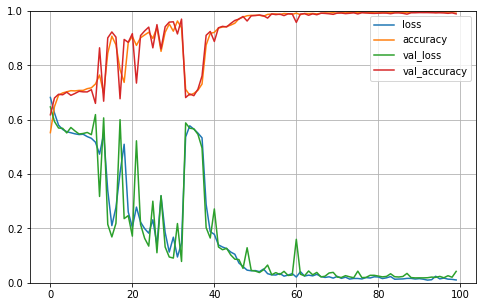

MODEL
make_DNN
input shape: (128, 4)
FIT
Epoch 1/100
2667/2667 [==============================] - 40s 14ms/step - loss: 0.6893 - accuracy: 0.5448 - val_loss: 0.6332 - val_accuracy: 0.6417
Epoch 2/100
2667/2667 [==============================] - 35s 13ms/step - loss: 0.6269 - accuracy: 0.6480 - val_loss: 0.5700 - val_accuracy: 0.6947
Epoch 3/100
2667/2667 [==============================] - 35s 13ms/step - loss: 0.5764 - accuracy: 0.6914 - val_loss: 0.5592 - val_accuracy: 0.6999
Epoch 4/100
 995/2667 [==========>...................] - ETA: 18s - loss: 0.5610 - accuracy: 0.6949

In [ ]:
do_cross_validation(X,y)

In [ ]:
from keras.models import load_model
X,y = prepare_inputs_len_x_alphabet(pc_test,nc_test,ALPHABET)
best_model=load_model(MODELPATH)
scores = best_model.evaluate(X, y, verbose=0)
print("The best model parameters were saved during cross-validation.")
print("Best was defined as maximum validation accuracy at end of any epoch.")
print("Now re-load the best model and test it on previously unseen data.")
print("Test on",len(pc_test),"PC seqs")
print("Test on",len(nc_test),"NC seqs")
print("%s: %.2f%%" % (best_model.metrics_names[1], scores[1]*100))


In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
ns_probs = [0 for _ in range(len(y))]
bm_probs = best_model.predict(X)
ns_auc = roc_auc_score(y, ns_probs)
bm_auc = roc_auc_score(y, bm_probs)
ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
bm_fpr, bm_tpr, _ = roc_curve(y, bm_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Guess, auc=%.4f'%ns_auc)
plt.plot(bm_fpr, bm_tpr, marker='.', label='Model, auc=%.4f'%bm_auc)
plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
print("%s: %.2f%%" %('AUC',bm_auc*100.0))


In [ ]:
t = time.time()
time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t))